# Analysis of b_eff results from HPCC

This notebook analyses the results of the latency/bandwidth measurements from the HPCC (HPC Challenge) benchmarks for a variety of HPC systems.

## Setup section

Load required modules and define useful functions

In [3]:
import re
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
sns.set_context("paper")

This function extracts the b_eff results from the HPCC output file

In [4]:
def getbeffres(resfilename):
    infile = open(resfilename, 'r')
    pingpong = {}
    randring = {}
    natring = {}
    indata = False
    nline = 0
    for line in infile:
        if indata:
            nline += 1
            if nline == 2:
                # pp latency, e.g.:
                # Latency   min / avg / max:   0.001237 /   0.001749 /   0.004679 msecs
                line = line.strip()
                tokens = line.split()
                pingpong['min_lat'] = float(tokens[6])
                pingpong['mean_lat'] = float(tokens[8])
                pingpong['max_lat'] = float(tokens[10])
            elif nline == 3:
                # pp bw, e.g.:
                # Bandwidth min / avg / max:   3053.734 /   7057.902 /   8909.833 MByte/s
                line = line.strip()
                tokens = line.split()
                pingpong['min_bw'] = float(tokens[6])
                pingpong['mean_bw'] = float(tokens[8])
                pingpong['max_bw'] = float(tokens[10])
            elif nline == 5:
                # nat ring, e.g.:
                # On naturally ordered ring: latency= 0.001597 msec, bandwidth= 3773.552857 MB/s
                line = line.strip()
                tokens = line.split()
                randring['lat'] = float(tokens[5])
                randring['bw'] = float(tokens[8])
            elif nline == 6:
                # rand ring, e.g:
                # On randomly  ordered ring: latency= 0.003608 msec, bandwidth= 4065.500726 MB/s
                natring['lat'] = float(tokens[5])
                natring['bw'] = float(tokens[8])
                break
        else:
            if re.match('Detailed', line):
                indata = True
                nline = 0

    infile.close()

    return pingpong, randring, natring

Small function to get the results from files into lists for plotting. 'restype' specifies whether to extract random ring ('rr') or natural ring ('nr'). This is inefficient as we re-read the files each time to extract the data but the number of files should be low so this is not currently a problem.

In [5]:
def calcperf(filedict, cpn, restype='rr'):
    coreslist = []
    bw = []
    lat = []
    if restype == 'rr':
        print "Random Ring results:"
    elif restype == 'nr':
        print "Random Ring results:"
    print "{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'BW (GiB/s)', 'Lat. (us)')
    print "{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '==========', '=========')
    for nodes, filename in sorted(filedict.items()):
        pp, rr, nr = getbeffres(filename)
        coreslist.append(nodes*cpn)
        tbw = None
        tlat = None
        if restype == 'rr':
            tbw = rr['bw']/1024.0
            tlat = rr['lat']*1000
        if restype == 'nr':
            tbw = nr['bw']/1024.0
            tlat = nr['lat']*1000
        bw.append(tbw)
        lat.append(tlat)
        print "{:>15d} {:>15d} {:>15.3f} {:>15.3f}".format(nodes, nodes*cpn, tbw, tlat)
    return coreslist, bw, lat
        

## ARCHER

Fully-populated nodes

In [6]:
archerfiles = {2:'../beff_results/ARCHER/nodes2ppn24_201708301007_hpccoutf.txt',
               4:'../beff_results/ARCHER/nodes4ppn24_201708301006_hpccoutf.txt',
               8:'../beff_results/ARCHER/nodes8ppn24_201708301005_hpccoutf.txt',
               16:'../beff_results/ARCHER/nodes16ppn24_201708301004_hpccoutf.txt',
               32:'../beff_results/ARCHER/nodes32ppn24_201708301003_hpccoutf.txt',
               64:'../beff_results/ARCHER/nodes64ppn24_hpccoutf.txt',
               128:'../beff_results/ARCHER/nodes128ppn24_hpccoutf.txt',
               256:'../beff_results/ARCHER/nodes256ppn24_hpccoutf.txt'}

In [7]:
archercpn = 24
archercores, archer_rrbw, archer_rrlat = calcperf(archerfiles, archercpn, restype='rr')

Random Ring results:
          Nodes           Cores      BW (GiB/s)       Lat. (us)
          =====           =====      ==========       =========
              2              48           1.344           1.097
              4              96           1.319           1.299
              8             192           1.281           1.431
             16             384           1.205           1.800
             32             768           1.210           1.657
             64            1536           1.198           2.348
            128            3072           1.183           2.929
            256            6144           1.094           3.850


## Cirrus

Fully-populated nodes

In [8]:
cirrusfiles = {2:'../beff_results/Cirrus/nodes2ppn36_201709182205_hpccoutf.txt',
               4:'../beff_results/Cirrus/nodes4ppn36_201709182205_hpccoutf.txt',
               8:'../beff_results/Cirrus/nodes8ppn36_201709182204_hpccoutf.txt',
               16:'../beff_results/Cirrus/nodes16ppn36_201709182203_hpccoutf.txt',
               32:'../beff_results/Cirrus/nodes32ppn36_201709182202_hpccoutf.txt'}

In [9]:
cirruscpn = 36
cirruscores, cirrus_rrbw, cirrus_rrlat = calcperf(cirrusfiles, cirruscpn, restype='rr')

Random Ring results:
          Nodes           Cores      BW (GiB/s)       Lat. (us)
          =====           =====      ==========       =========
              2              72           1.636           0.933
              4             144           1.406           1.115
              8             288           1.365           1.078
             16             576           1.339           1.285
             32            1152           1.339           1.459


## Athena

Fully-populated nodes

In [10]:
athenafiles = {2:'../beff_results/Athena/nodes2ppn28_201708301452_hpccoutf.txt',
               4:'../beff_results/Athena/nodes4ppn28_201708301452_hpccoutf.txt',
               8:'../beff_results/Athena/nodes8ppn28_201708301451_hpccoutf.txt',
               16:'../beff_results/Athena/nodes16ppn28_201708301450_hpccoutf.txt'}

In [11]:
athenacpn = 28
athenacores, athena_rrbw, athena_rrlat = calcperf(athenafiles, athenacpn, restype='rr')

Random Ring results:
          Nodes           Cores      BW (GiB/s)       Lat. (us)
          =====           =====      ==========       =========
              2              56           1.643           0.799
              4             112           1.651           0.846
              8             224           1.628           0.906
             16             448           1.589           0.954


## CSD3-Skylake

Fully-populated nodes

In [12]:
csd3sfiles = {2:'../beff_results/CSD3Skylake/nodes2ppn32_201711232059_hpccoutf.txt',
              4:'../beff_results/CSD3Skylake/nodes4ppn32_201711232109_hpccoutf.txt',
              8:'../beff_results/CSD3Skylake/nodes8ppn32_201711232113_hpccoutf.txt',
              16:'../beff_results/CSD3Skylake/nodes16ppn32_201711232116_hpccoutf.txt',
              16:'../beff_results/CSD3Skylake/nodes32ppn32_201711232118_hpccoutf.txt'
             }

In [13]:
csd3scpn = 32
csd3scores, csd3s_rrbw, csd3s_rrlat = calcperf(csd3sfiles, csd3scpn, restype='rr')

Random Ring results:
          Nodes           Cores      BW (GiB/s)       Lat. (us)
          =====           =====      ==========       =========
              2              64           1.469           1.277
              4             128           1.416           1.362
              8             256           0.834           1.362
             16             512           0.793           1.431


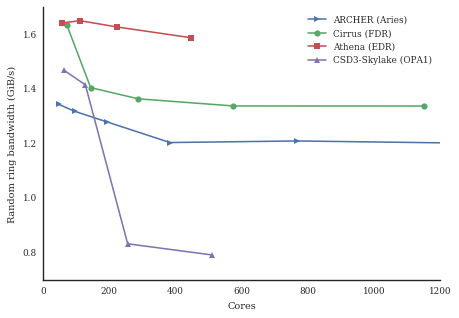

In [14]:
plt.plot(archercores, archer_rrbw, '>-', label='ARCHER (Aries)')
plt.plot(cirruscores, cirrus_rrbw, 'o-', label='Cirrus (FDR)')
plt.plot(athenacores, athena_rrbw, 's-', label='Athena (EDR)')
plt.plot(csd3scores, csd3s_rrbw, '^-', label='CSD3-Skylake (OPA1)')
plt.xlabel('Cores')
plt.ylabel('Random ring bandwidth (GiB/s)')
plt.xlim(0,1200)
plt.legend(loc='best')
sns.despine()

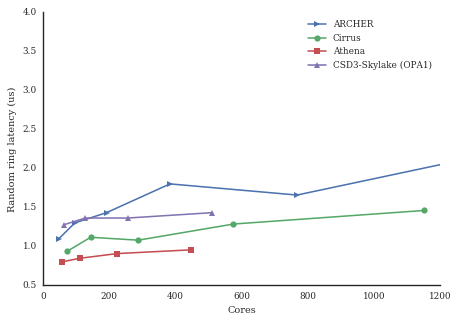

In [16]:
plt.plot(archercores, archer_rrlat, '>-', label='ARCHER')
plt.plot(cirruscores, cirrus_rrlat, 'o-', label='Cirrus')
plt.plot(athenacores, athena_rrlat, 's-', label='Athena')
plt.plot(csd3scores, csd3s_rrlat, '^-', label='CSD3-Skylake (OPA1)')
plt.xlabel('Cores')
plt.ylabel('Random ring latency (us)')
plt.xlim(0,1200)
plt.legend(loc='best')
sns.despine()